In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import norm

Набор данных состоит из всех фильмов производства Netflix, выпущенных по состоянию на 1 июня 2021 года. Кроме того, он также включает все документальные фильмы и специальные материалы Netflix. 
Содержание набора данных:
-	Название фильма
-	Жанр фильма
-	Дата премьеры
-   Длительность в минутах
-	Баллы IMDB (по состоянию на 01.06.21)
-	Доступные языки (по состоянию на 01.06.21)

Требуется ответить на следующие вопросы:
1.	Фильмы какого жанра наиболее популярные? А какого менее?
2.	На каком языке Netflix чаще всего снимает фильмы?
3.	Есть ли зависимость между длительностью фильма и его рейтингом?
4.	Порекомендуйте, на какой месяц лучше всего запланировать премьеру нового фильма. Почему? 

In [22]:
df = pd.read_csv('NetflixOriginals.csv')

In [23]:
df.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language
0,"Enter the Anime,Documentary,""August 5, 2019"",5...",NaN,NaN,NaN,NaN,NaN
1,"Dark Forces,Thriller,""August 21, 2020"",81,2.6,...",NaN,NaN,NaN,NaN,NaN
2,"The App,Science fiction/Drama,""December 26, 20...",NaN,NaN,NaN,NaN,NaN
3,"The Open House,Horror thriller,""January 19, 20...",NaN,NaN,NaN,NaN,NaN
4,"Kaali Khuhi,Mystery,""October 30, 2020"",90,3.4,...",NaN,NaN,NaN,NaN,NaN


### Сразу не получилось считать данные в DF по колонкам, посмотрим, как это исправить

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       584 non-null    object 
 1   Genre       5 non-null      object 
 2   Premiere    5 non-null      object 
 3   Runtime     5 non-null      float64
 4   IMDB Score  5 non-null      float64
 5   Language    5 non-null      object 
dtypes: float64(2), object(4)
memory usage: 27.5+ KB


In [25]:
# Видим, что в столбцах присутствуют значения без пропусков, посмотрим на них
df[df['Genre'].notna()]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
111,Ghosts of Sugar Land,Documentary,October 16. 2019,21.0,5.5,English
308,Strong Island,Documentary,September 15. 2017,107.0,6.4,English
387,Tony Robbins: I Am Not Your Guru,Documentary,July 15. 2016,116.0,6.7,English
538,Joan Didion: The Center Will Not Hold,Documentary,October 27. 2017,98.0,7.5,English
541,The White Helmets,Documentary,September 16. 2016,40.0,7.5,English


В пяти строках данные прочитались нормально, выделим их в отдельный df. Чтобы не переписывать в ручную, создадим список с индексами, где нет пропусков.

In [26]:
idx_notnull = list(df[df['Genre'].notna()].index)
print(idx_notnull)

[111, 308, 387, 538, 541]


In [27]:
df_1 = df.iloc[idx_notnull]

In [28]:
df_1

,Title,Genre,Premiere,Runtime,IMDB Score,Language
111,Ghosts of Sugar Land,Documentary,October 16. 2019,21.0,5.5,English
308,Strong Island,Documentary,September 15. 2017,107.0,6.4,English
387,Tony Robbins: I Am Not Your Guru,Documentary,July 15. 2016,116.0,6.7,English
538,Joan Didion: The Center Will Not Hold,Documentary,October 27. 2017,98.0,7.5,English
541,The White Helmets,Documentary,September 16. 2016,40.0,7.5,English


Переведём столбец с датой в формат даты

In [29]:
df_1['Premiere'] = pd.to_datetime(df_1['Premiere'], format='%B %d. %Y')

<ipython-input-29-ad7396bb996f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Premiere'] = pd.to_datetime(df_1['Premiere'], format='%B %d. %Y')


Создадим новый дата фрейм, в котором удалим пять строк, которые оказались в отличном формате от остальных

In [30]:
df_big = df.drop(index=idx_notnull)

In [31]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 583
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       579 non-null    object 
 1   Genre       0 non-null      object 
 2   Premiere    0 non-null      object 
 3   Runtime     0 non-null      float64
 4   IMDB Score  0 non-null      float64
 5   Language    0 non-null      object 
dtypes: float64(2), object(4)
memory usage: 31.7+ KB


### Раздалим данные из исходного DF по столбцам и создадим промежуточные DF.
В связи с тем, что запятые встречаются в названиях фильмов и в датах, мы не можем сразу разделить данные по запятым, поэтому столбцы с названиями фильмов и с датой выхода будем выделять отдельно

In [32]:
df_big.columns

Index(['Title', 'Genre', 'Premiere', 'Runtime', 'IMDB Score', 'Language'], dtype='object')

In [33]:
# удалим колонки без данных
df_big = df_big.drop(['Genre', 'Premiere', 'Runtime', 'IMDB Score', 'Language'], axis=1) 

In [34]:
df_big.head()

,Title
0,"Enter the Anime,Documentary,""August 5, 2019"",5..."
1,"Dark Forces,Thriller,""August 21, 2020"",81,2.6,..."
2,"The App,Science fiction/Drama,""December 26, 20..."
3,"The Open House,Horror thriller,""January 19, 20..."
4,"Kaali Khuhi,Mystery,""October 30, 2020"",90,3.4,..."


In [35]:
df_big = df_big.iloc[:, 0].str.split(',"', expand=True) 
# разделим значения на столбцы, для начала отделим столбец с датой, который выделен ковычками

In [36]:
df_0_1_col = df_big.iloc[:, 0].str.rsplit(',', 1, expand=True) 
# запишем первые два столбца в дата фрейм, разделитель исходных значений - последняя запятая

In [37]:
df_big = df_big.drop(0, axis=1) # удалим значения, которые мы записали в новый дата фрейм

In [38]:
df_0_1_col.head() # первые два столбца

,0,1
0,Enter the Anime,Documentary
1,Dark Forces,Thriller
2,The App,Science fiction/Drama
3,The Open House,Horror thriller
4,Kaali Khuhi,Mystery


In [39]:
df_2_col = df_big.iloc[:, 0].str.split('",', expand=True)[0] # выделим столбец с датой

In [40]:
df_2_col = pd.to_datetime(df_2_col, format='%B %d, %Y') # переведём в формат даты "datetime"

In [41]:
df_big = df_big.iloc[:, 0].str.split('",', expand=True)[1] 
# оставим в дата фрейме значения, которые еще не разделены по столбцам

In [42]:
df_3_4_5_col = df_big.str.split(',', expand=True) # создадим дф с последними тремя столбцами

### Соберём данные из промежуточных DF в один 

In [43]:
netflix = df_0_1_col

In [44]:
netflix['Premiere'] = df_2_col

In [45]:
netflix = pd.concat([netflix, df_3_4_5_col], axis =1)

In [46]:
netflix.columns = df_1.columns

In [47]:
netflix = pd.concat([netflix, df_1], axis =0)

In [48]:
netflix.rename(columns={
    'IMDB Score' : 'IMDB_Score'
}, inplace=True)

In [49]:
netflix.head()

,Title,Genre,Premiere,Runtime,IMDB_Score,Language
0,Enter the Anime,Documentary,2019-08-05,58,2.5,English/Japanese
1,Dark Forces,Thriller,2020-08-21,81,2.6,Spanish
2,The App,Science fiction/Drama,2019-12-26,79,2.6,Italian
3,The Open House,Horror thriller,2018-01-19,94,3.2,English
4,Kaali Khuhi,Mystery,2020-10-30,90,3.4,Hindi


In [50]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 541
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Title       584 non-null    object        
 1   Genre       584 non-null    object        
 2   Premiere    584 non-null    datetime64[ns]
 3   Runtime     584 non-null    object        
 4   IMDB_Score  584 non-null    object        
 5   Language    584 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 31.9+ KB


Переведем столбцы в подходящие форматы

In [51]:
netflix.Runtime = netflix.Runtime.astype(int)
netflix.IMDB_Score = netflix.IMDB_Score.astype(float)

In [52]:
netflix.describe(include='all', datetime_is_numeric=True)

,Title,Genre,Premiere,Runtime,IMDB_Score,Language
count,584,584,584,584.000000,584.000000,584
unique,584,115,NaN,NaN,NaN,38
top,The Fundamentals of Caring,Documentary,NaN,NaN,NaN,English
freq,1,159,NaN,NaN,NaN,401
mean,NaN,NaN,2019-06-20 01:04:06.575342592,93.577055,6.271747,NaN
min,NaN,NaN,2014-12-13 00:00:00,4.000000,2.500000,NaN
25%,NaN,NaN,2018-06-27 18:00:00,86.000000,5.700000,NaN
50%,NaN,NaN,2019-10-17 00:00:00,97.000000,6.350000,NaN
75%,NaN,NaN,2020-09-18 18:00:00,108.000000,7.000000,NaN
max,NaN,NaN,2021-05-27 00:00:00,209.000000,9.000000,NaN


# 1. Фильмы какого жанра наиболее популярные? А какого менее?

In [53]:
netflix.head()

,Title,Genre,Premiere,Runtime,IMDB_Score,Language
0,Enter the Anime,Documentary,2019-08-05,58,2.5,English/Japanese
1,Dark Forces,Thriller,2020-08-21,81,2.6,Spanish
2,The App,Science fiction/Drama,2019-12-26,79,2.6,Italian
3,The Open House,Horror thriller,2018-01-19,94,3.2,English
4,Kaali Khuhi,Mystery,2020-10-30,90,3.4,Hindi


### Посчитаем, сколько фильмов каждого жанра имеется в данных

In [54]:
genres = netflix.groupby('Genre', as_index=False)\
                .agg({'Title': 'count', 'IMDB_Score': 'mean'})\
                .rename(columns={'Title': 'Quantity'})\
                .sort_values(by='Quantity', ascending=False)
genres.IMDB_Score = round(genres.IMDB_Score, 2)

In [55]:
genres.head(15)

,Genre,Quantity,IMDB_Score
45,Documentary,159,6.94
46,Drama,77,6.34
32,Comedy,49,5.51
81,Romantic comedy,39,5.85
106,Thriller,33,5.56
36,Comedy-drama,14,6.21
41,Crime drama,11,6.75
26,Biopic,9,6.40
60,Horror,9,5.26
0,Action,7,5.41


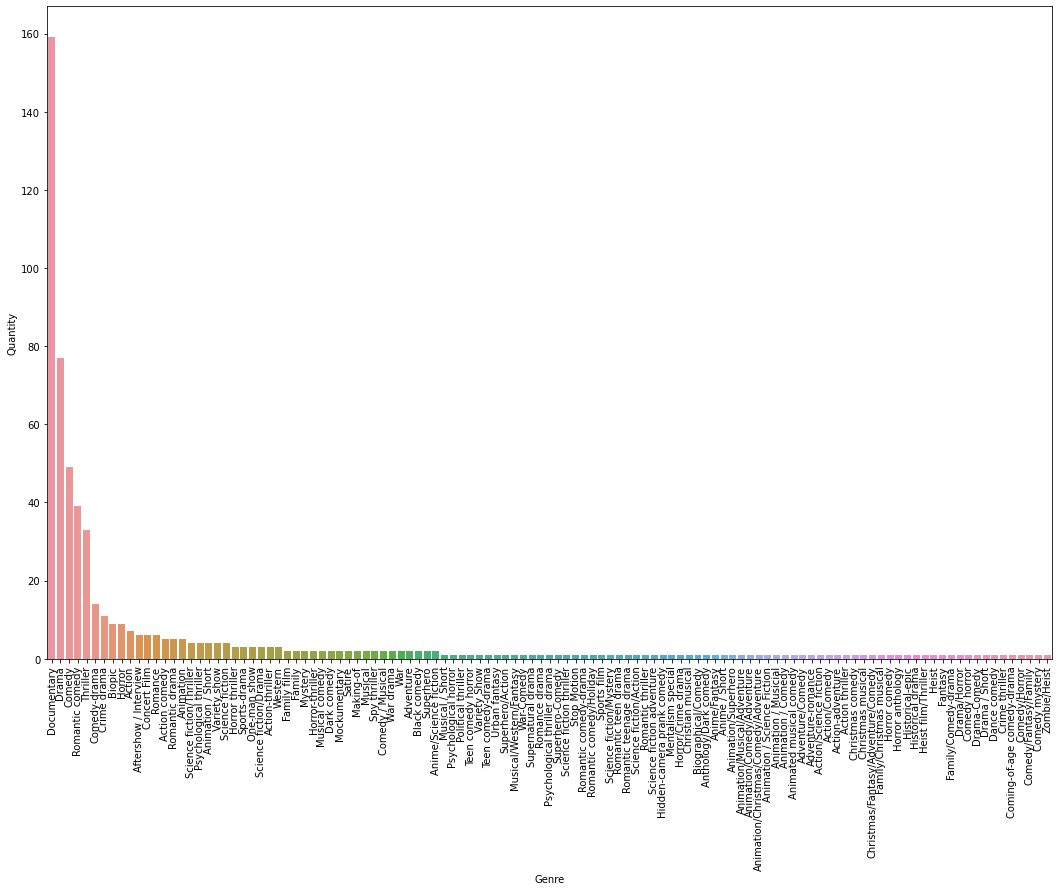

In [56]:
plt.figure(figsize=(18, 12))
sns.barplot(data=genres, x="Genre", y="Quantity")
plt.xticks(rotation=90)
plt.show()

### За меру популярности жанра возьмём количество фильмов, которые были выпущены в этом жанре. В исходных данных имеется много смешанных жанров, будем считать их за отдельные жанры, которые имеют свою целевую аудиторию.

In [57]:
genres.nlargest(n=10, columns='Quantity')

,Genre,Quantity,IMDB_Score
45,Documentary,159,6.94
46,Drama,77,6.34
32,Comedy,49,5.51
81,Romantic comedy,39,5.85
106,Thriller,33,5.56
36,Comedy-drama,14,6.21
41,Crime drama,11,6.75
26,Biopic,9,6.40
60,Horror,9,5.26
0,Action,7,5.41


### Наиболее популярны документальные фильмы, на втором месте по популярности драмы, на третьем комедии

In [58]:
genres.query('Quantity == 1').sort_values(by='IMDB_Score').shape[0]

70

In [59]:
genres.query('Quantity == 1').sort_values(by='IMDB_Score').head(10) # примеры наименее популярных жанров

,Genre,Quantity,IMDB_Score
56,Heist film/Thriller,1,3.7
72,Musical/Western/Fantasy,1,3.9
61,Horror anthology,1,4.3
75,Political thriller,1,4.3
101,Superhero-Comedy,1,4.4
80,Romance drama,1,4.6
21,Anime / Short,1,4.7
55,Heist,1,4.8
20,Animation/Superhero,1,4.9
105,Teen comedy-drama,1,5.1


### Наименее популярны фильмы смешанных жанров, таких жанров в исходных данных насчитывается 70

# 2. На каком языке Netflix чаще всего снимает фильмы?

In [60]:
language = netflix.groupby('Language', as_index=False)\
                  .agg({'Title': 'count'})\
                  .rename(columns={'Title': 'Quantity'})

In [61]:
language.nlargest(n=10, columns='Quantity')

,Language,Quantity
2,English,401
18,Hindi,33
29,Spanish,31
15,French,20
20,Italian,14
28,Portuguese,12
19,Indonesian,9
21,Japanese,6
23,Korean,6
10,English/Spanish,5


### Больше всего фильмов снято на английском языке

# 3. Есть ли зависимость между длительностью фильма и его рейтингом?

In [62]:
runtime = netflix.sort_values(by='Runtime', ascending=False)

Посмотрим на графике взаимосвязь длительности фильма и его рейтинга

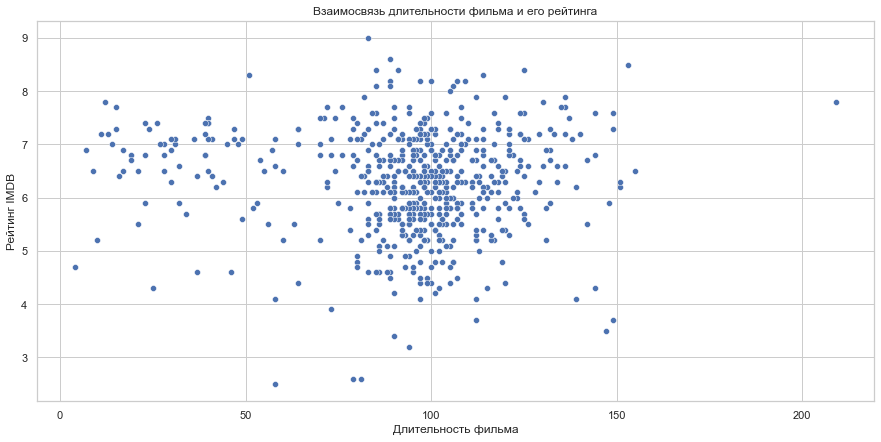

In [63]:
sns.set(style='whitegrid', rc={'figure.figsize' : (15,7)})
plt.title('Взаимосвязь длительности фильма и его рейтинга')
plt.xlabel('Длительность фильма')
plt.ylabel('Рейтинг IMDB')
sns.scatterplot(x = 'Runtime', y = 'IMDB_Score', data = runtime);

На приведённом графике визуально взаимосвязь не улавливается. Построим матрицу корреляций

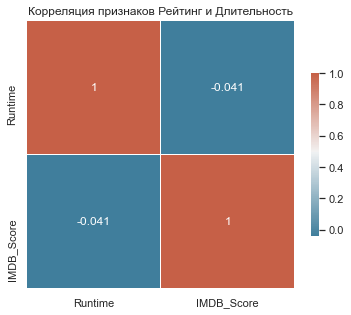

In [64]:
corr = runtime[['Runtime', 'IMDB_Score']].corr()

sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(6,6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, center=0.5, annot=corr,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляция признаков Рейтинг и Длительность')
plt.show()

Нет линейной взаимосвязи, но может быть и другая более сложная

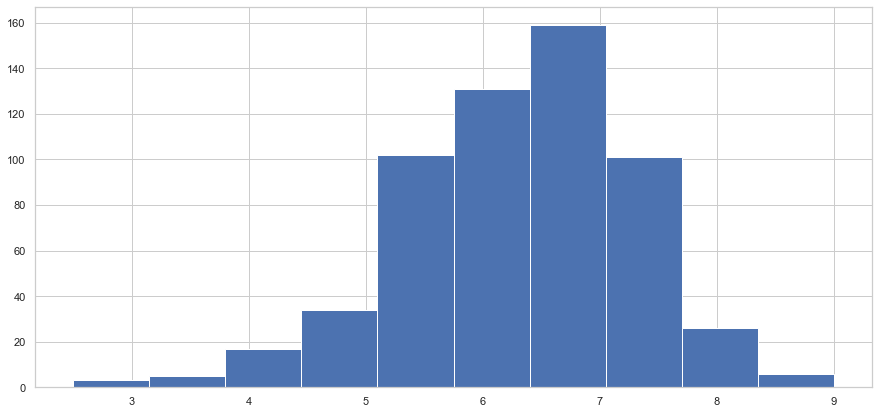

In [65]:
#Проверим распределение для выбора типа теста
plt.hist(runtime['IMDB_Score'])
plt.show()

Видим, что распределение близко к нормальному и не имеет сильных ассиметрий.

Разделим данные на две одинаковые выборки по длительности фильма - короткие фильмы и длинные.

In [66]:
runtime['duration_label'] = pd.qcut(runtime.Runtime, 2, labels=["short", "long"])

In [67]:
runtime.head()

,Title,Genre,Premiere,Runtime,IMDB_Score,Language,duration_label
561,The Irishman,Crime drama,2019-11-27,209,7.8,English,long
328,Da 5 Bloods,War drama,2020-06-12,155,6.5,English,long
581,Springsteen on Broadway,One-man show,2018-12-16,153,8.5,English,long
247,Citation,Drama,2020-11-06,151,6.2,English,long
284,The Forest of Love,Drama,2019-10-11,151,6.3,Japanese,long


Создаем функцию для проверки гипотезы с помощью бутстрапа. В качестве нулевой гипотезы примем, что различий нет. Уровень значимости альфа примем 0.05

In [68]:
def get_bootstrap(sample1, sample2, iterate=1000, alpha=0.05, statistic='mean', random_state=42):
    
    assert statistic in ('mean', 'median'), f'{statistic} not in correct statistics. Choose "mean" or "median"'
    np.random.seed(random_state)
    l = max(len(sample1), len(sample2))
    difference = []
    for i in range(iterate):
        s1 = np.random.choice(sample1, size=l, replace=True)
        s2 = np.random.choice(sample2, size=l, replace=True)
        if statistic == 'mean':
            diff = np.mean(s1 - s2)
        else: 
            diff = np.median(s1 - s2)
        difference.append(diff)
    low_quantile = alpha/2
    upper_quantile = 1 - low_quantile 
    ci = (np.quantile(difference, low_quantile), np.quantile(difference, upper_quantile))
    p1 = norm.cdf(0, loc=np.mean(difference), scale=np.std(difference))
    p2 = 1 - p1
    p = min(p1, p2)*2
    
    plt.hist(difference, bins = 50)

    with plt.style.context('bmh'):
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": difference, 
            "ci": ci, 
            "p_value": p
           }

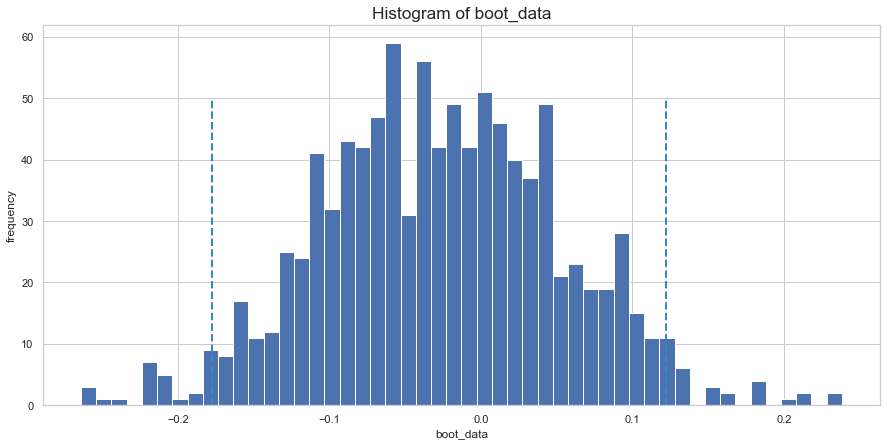

In [69]:
result_mean = get_bootstrap(runtime.query('duration_label == "short"').IMDB_Score, 
                            runtime.query('duration_label == "long"').IMDB_Score, statistic='mean')

In [70]:
result_mean['p_value'] # P-value > 0.05, а значит мы не можем отклонить нулевую гипотизу о том, что нет различий в выборках

0.7421097551941251

In [71]:
result_mean['ci'] 
# доверительный интервал включает ноль, что говорит о том, различий между разницами средних двух выборок не наблюдается

(-0.1771605960264901, 0.12254139072847682)

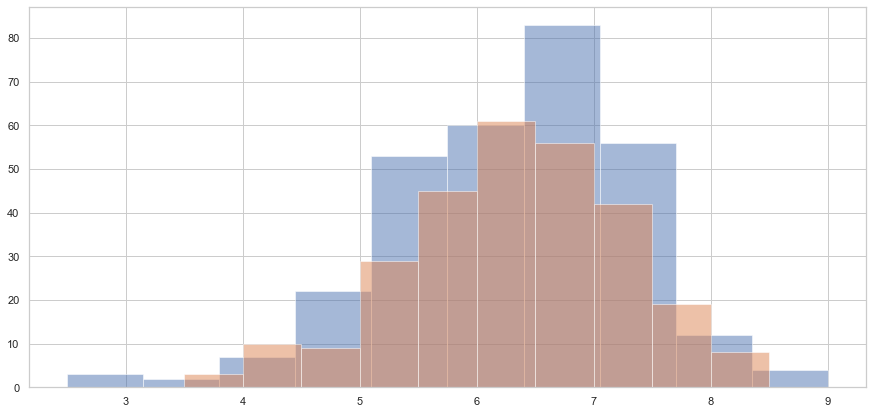

In [72]:
#Посмотрим распределение двух выборок
plt.hist(runtime.query('duration_label == "short"').IMDB_Score, alpha=0.5)
plt.hist(runtime.query('duration_label == "long"').IMDB_Score, alpha=0.5)
plt.show()

### Взаимосвязь длительности фильма и его рейтинга не прослеживается

# 4. Порекомендуйте, на какой месяц лучше всего запланировать премьеру нового фильма. Почему? 

### Премьеру нового фильма лучше всего запланировать на тот месяц, когда на него придёт больше всего зрителей. Посмотрим, в какой месяц фильмы выпускались чаще всего, скорее всего этот месяц наилучший для премьеры.

In [73]:
premiere = netflix.sort_values(by='Premiere')

In [74]:
premiere['Year_Month_of_premiere'] = premiere.Premiere.dt.strftime('%Y-%m') 

In [75]:
premiere_ymonth = premiere.groupby('Year_Month_of_premiere', as_index=False)\
        .agg({'Title': 'count'})\
        .rename(columns={'Title': 'Quantity'})

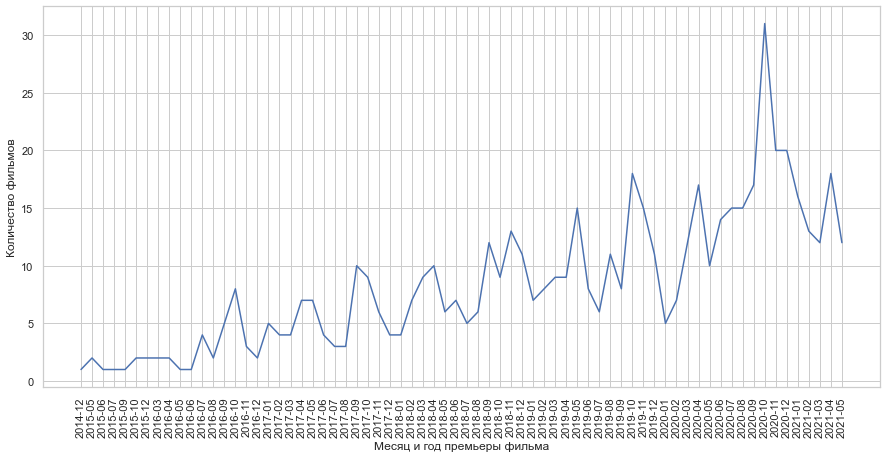

In [76]:
sns.lineplot(data=premiere_ymonth, x="Year_Month_of_premiere", y="Quantity")
plt.xlabel('Месяц и год премьеры фильма')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=90);

In [77]:
premiere['Month_of_premiere'] = premiere.Premiere.dt.month

In [78]:
premiere_gr = premiere.groupby('Month_of_premiere', as_index=False)\
        .agg({'Title': 'count', 'IMDB_Score': 'mean'})\
        .rename(columns={'Title': 'Quantity'})

In [79]:
premiere_gr

,Month_of_premiere,Quantity,IMDB_Score
0,1,37,6.002703
1,2,39,6.117949
2,3,48,6.322917
3,4,63,6.049206
4,5,53,6.213208
5,6,35,6.582857
6,7,34,6.091176
7,8,37,5.951351
8,9,53,6.481132
9,10,77,6.522078


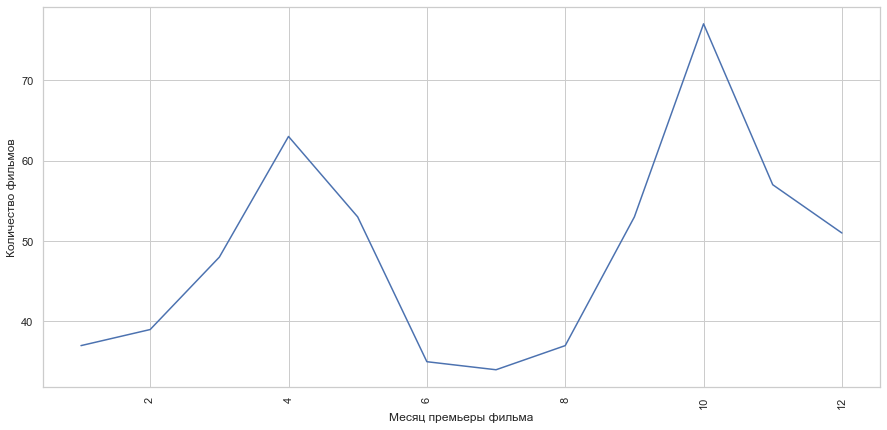

In [80]:
sns.lineplot(data=premiere_gr, x="Month_of_premiere", y="Quantity")
plt.xlabel('Месяц премьеры фильма')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=90);

### На графике мы видим сезонность выпуска фильмов, осенью, в октябре и сентябре больше всего лент выходит в прокат. Еще один всплеск мы видим весной, в апреле. Исходя из этих данных можно предположить, что в октябре кинотеатр посещает больше всего пользователей. Из этих соображений, премьеру лучше всего запланировать на октябрь